# Ejercicio Analítica Avanzada de datos con PySpark

En este notebook realizaremos algunos ejercicios sobre el dataset `data/stocks_price_final.csv` 

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import col
from pyspark.sql.functions import min, max
import matplotlib.pyplot as plt
import seaborn as sns

Importamos el CSV y visualizamos el esquema.

In [2]:
ruta_csv = "data/stocks_price_final.csv"
df = spark.read.csv(
    ruta_csv,
    sep = ',',
    header = True
    )

df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- date: string (nullable = true)
 |-- open: string (nullable = true)
 |-- high: string (nullable = true)
 |-- low: string (nullable = true)
 |-- close: string (nullable = true)
 |-- volume: string (nullable = true)
 |-- adjusted: string (nullable = true)
 |-- market.cap: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- exchange: string (nullable = true)



En este caso, vamos a definir el esquema de este dataset, dado que no esta del todo correcto al inferirlo. 

Asi mismo, volveremos a leer el dataset para sobreescribirlo con la estructura correcta

In [3]:
data_schema = [
               StructField('_c0', IntegerType(), True),
               StructField('symbol', StringType(), True),
               StructField('data', DateType(), True),
               StructField('open', DoubleType(), True),
               StructField('high', DoubleType(), True),
               StructField('low', DoubleType(), True),
               StructField('close', DoubleType(), True),
               StructField('volume', IntegerType(), True),
               StructField('adjusted', DoubleType(), True),
               StructField('market.cap', StringType(), True),
               StructField('sector', StringType(), True),
               StructField('industry', StringType(), True),
               StructField('exchange', StringType(), True),
            ]

final_struc = StructType(fields=data_schema)

df = spark.read.csv(
    ruta_csv,
    sep = ',',
    header = True,
    schema = final_struc
    )

df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- symbol: string (nullable = true)
 |-- data: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- adjusted: double (nullable = true)
 |-- market.cap: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- exchange: string (nullable = true)



In [4]:
# Vamos a probar eliminar una columna
df = df.drop('market.cap')

df.columns

['_c0',
 'symbol',
 'data',
 'open',
 'high',
 'low',
 'close',
 'volume',
 'adjusted',
 'sector',
 'industry',
 'exchange']

In [5]:
# Vamos a eliminar las columnas en las cuales la variable 'open' sea nula
df_null_open = df.filter(col('open').isNull())
print(f"Tenemos {df_null_open.count()} columnas por borrar")

Tenemos 2733 columnas por borrar


In [6]:
# Esta secuencia es para verificar que hayamos eliminado correctamente las columnas
df_count_before = df.count()
print(f"El df en este momento tiene {df_count_before} columnas")

df = df.dropna(subset=['open'])

df_count_after = df.count()
print(f"El df en este momento tiene {df_count_after} columnas")

print(f"Se han eliminado {df_count_before - df_count_after} columnas")


El df en este momento tiene 1729034 columnas
El df en este momento tiene 1726301 columnas
Se han eliminado 2733 columnas


In [7]:
# Calculamos el mínimo y máximo de las columnas 'data', 'open', 'close' y 'adjusted'
min_max_values = df.select(
    min('data').alias('min_data'),
    max('data').alias('max_data'),
    min('open').alias('min_open'),
    max('open').alias('max_open'),
    min('close').alias('min_close'),
    max('close').alias('max_close'),
    min('adjusted').alias('min_adjusted'),
    max('adjusted').alias('max_adjusted')
).collect()[0]

# Obtenemos los valores mínimos y máximos
min_data = min_max_values['min_data']
max_data = min_max_values['max_data']
min_open = min_max_values['min_open']
max_open = min_max_values['max_open']
min_close = min_max_values['min_close']
max_close = min_max_values['max_close']
min_adjusted = min_max_values['min_adjusted']
max_adjusted = min_max_values['max_adjusted']

# Imprimimos los resultados
print(f"Mínimo 'data': {min_data}, Máximo 'data': {max_data}")
print(f"Mínimo 'open': {min_open}, Máximo 'open': {max_open}")
print(f"Mínimo 'close': {min_close}, Máximo 'close': {max_close}")
print(f"Mínimo 'adjusted': {min_adjusted}, Máximo 'adjusted': {max_adjusted}")


Mínimo 'data': 2019-01-02, Máximo 'data': 2020-07-22
Mínimo 'open': 0.072, Máximo 'open': 160168176.0
Mínimo 'close': 0.071, Máximo 'close': 158376592.0
Mínimo 'adjusted': -1.230099, Máximo 'adjusted': 157249392.0


In [8]:
# Vamos a preparar los datos para hacer una agrupación por Industria. 
sec_df =  df.select(['open', 'close', 'adjusted', 'industry']).groupBy('industry').mean().toPandas()

sec_df

,industry,avg(open),avg(close),avg(adjusted)
0,Finance/Investors Services,5.134402,5.136631,4.991354
1,Miscellaneous,16.385883,16.359879,16.148959
2,Investment Bankers/Brokers/Service,58.950581,58.983086,58.157837
3,Broadcasting,24.916787,24.917388,24.699102
4,Biotechnology: Biological Products (No Diagnos...,24.808083,24.803587,24.745080
...,...,...,...,...
130,Wholesale Distributors,16.608839,16.602717,16.602717
131,Electronics Distribution,6.428699,6.430408,6.377569
132,Tools/Hardware,70.412755,70.475944,69.670351
133,Tobacco,32.467832,32.455689,32.213047


<Axes: ylabel='industry'>

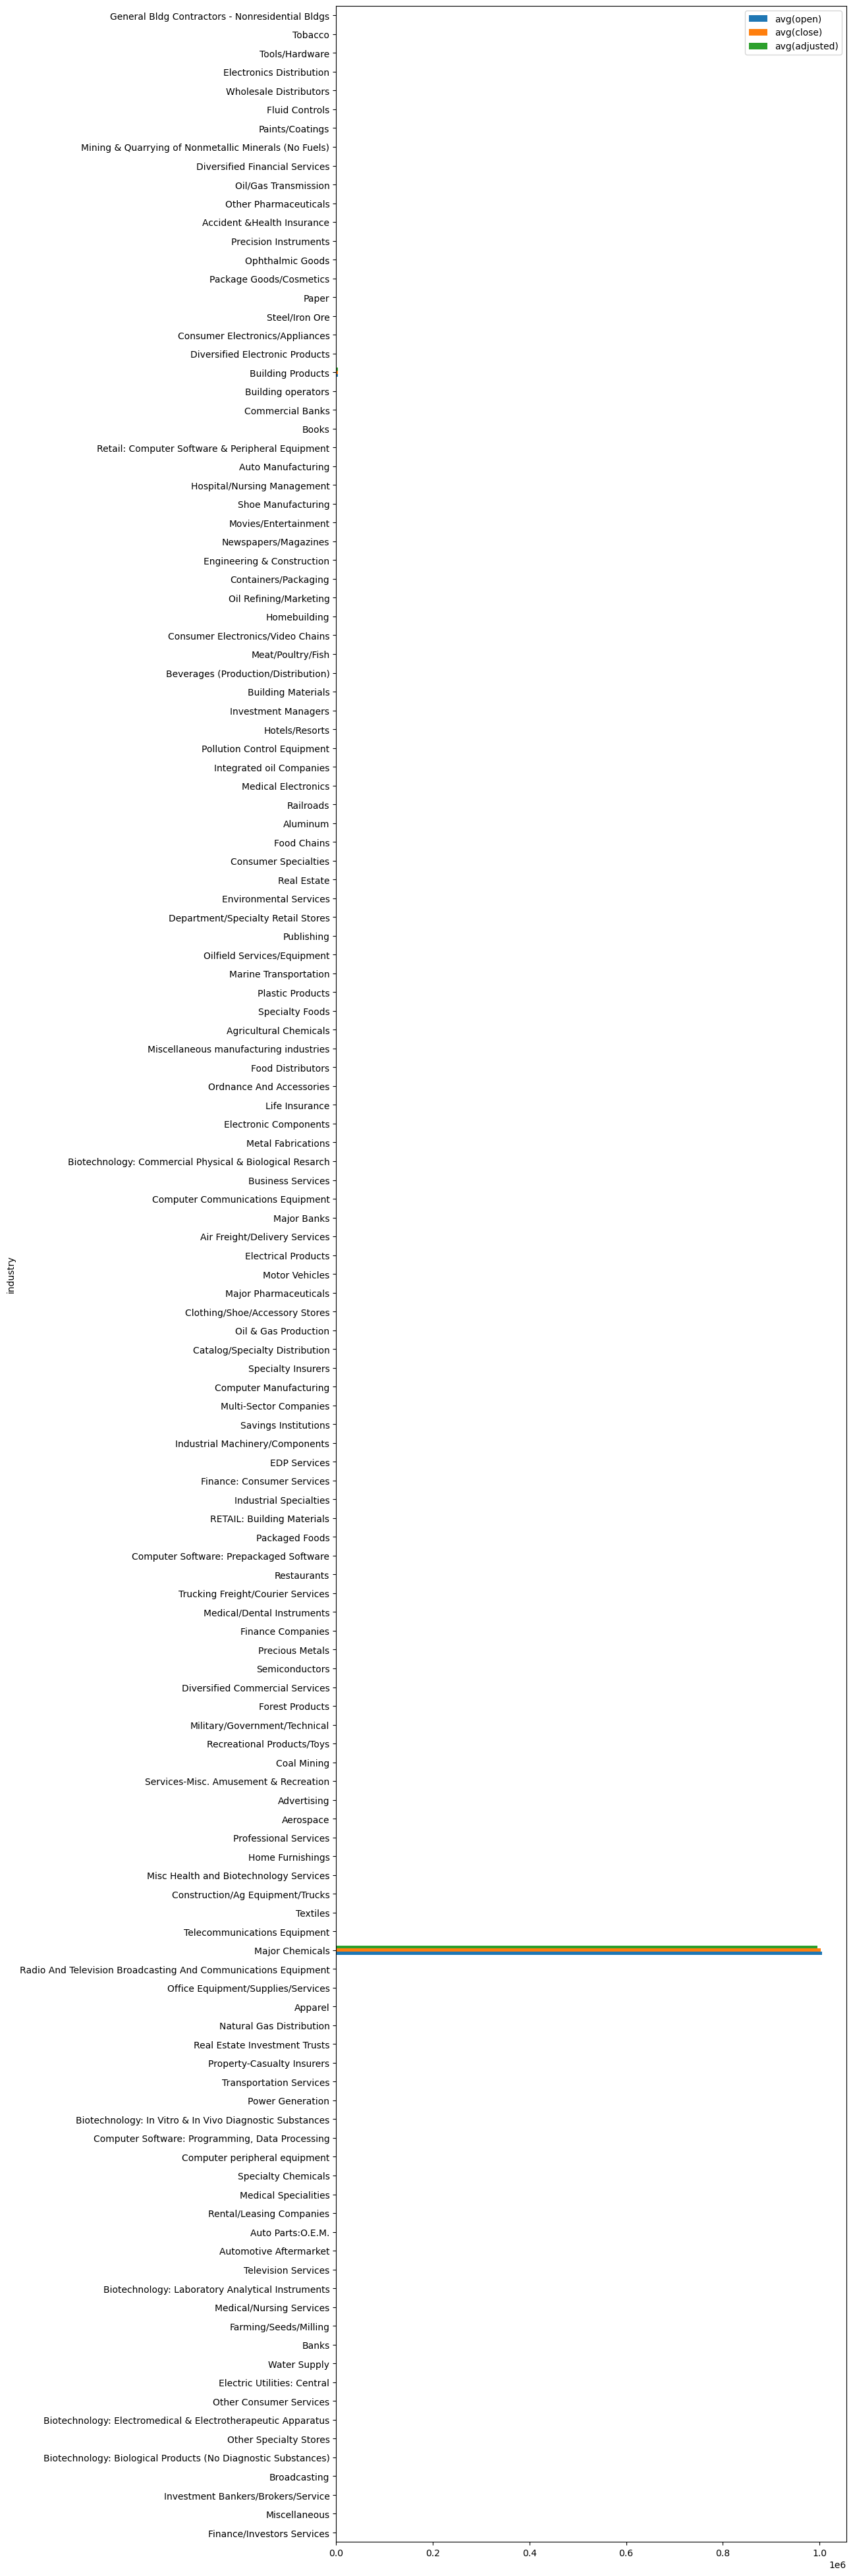

In [9]:
# Hacemos una primera visualización

sec_df.plot(kind = 'barh', x='industry', y = sec_df.columns.tolist()[1:], figsize=(10, 50))

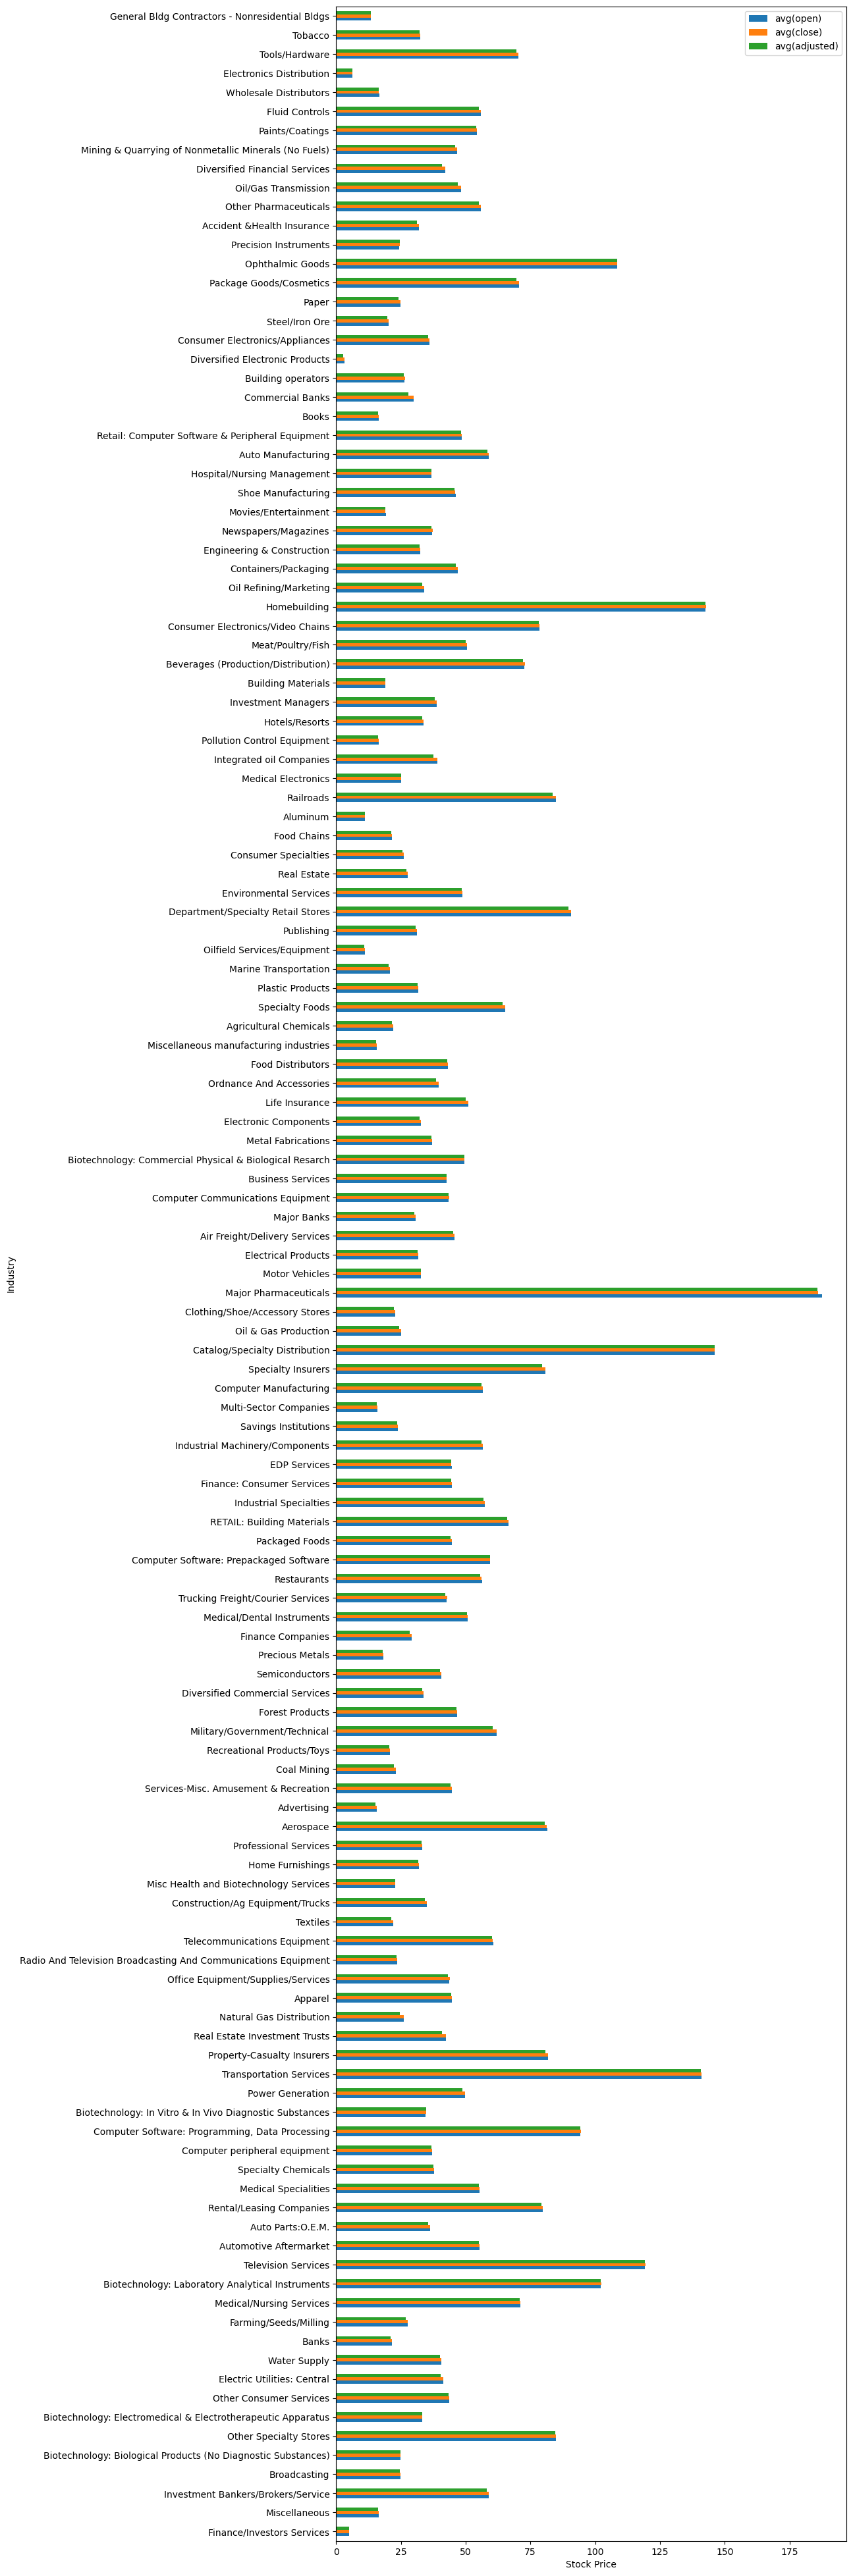

In [10]:
# Vamos a quitar los registros de Major Chemicals y Building Products para poder tener mejor visualización
# del resto de las industrias

q  = sec_df[(sec_df.industry != 'Major Chemicals') & (sec_df.industry != 'Building Products')]

q.plot(kind = 'barh', x='industry', y = q.columns.tolist()[1:], figsize=(10, 50), xlabel='Stock Price', ylabel = 'Industry')

plt.show()

Haremos un mapa de calor de correlaciones entre las medias de Open, Close y Adjusted

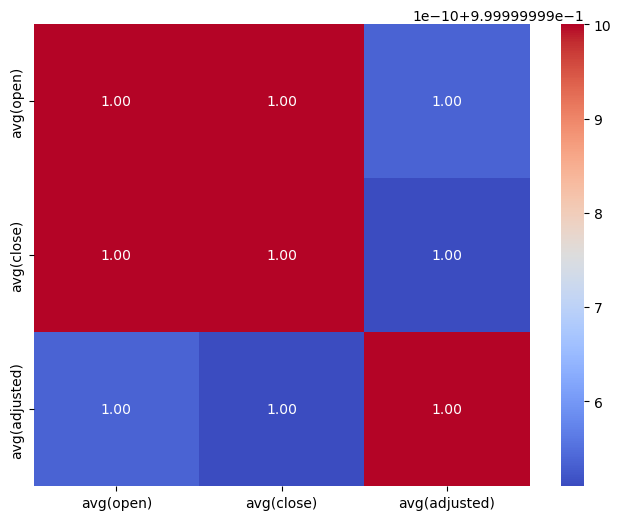

In [11]:
correlation_matrix = sec_df[['avg(open)', 'avg(close)', 'avg(adjusted)']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()